In [8]:
import numpy as np
import pandas as pd
import os
import pathlib
from matplotlib import pyplot

In [29]:
#locate file
cwd = os.getcwd()
filepath = list(pathlib.Path(cwd).rglob('*oe.csv'))

In [90]:
#file ingress
df = pd.read_csv(filepath[0])

In [43]:
#convert to timestamp for proper rendering in plt
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [44]:
#preview data
df.head()

,timestamp,Innodb_data_fsyncs,Threads_connected
0,2019-04-18 21:06:02.141726,8503802,65
1,2019-04-18 21:06:07.260973,8526335,65
2,2019-04-18 21:06:12.344215,8548645,65
3,2019-04-18 21:06:17.436656,8570947,65
4,2019-04-18 21:06:22.525223,8593404,65


In [45]:
#set datetime index for plotting, sanity checking var type
df = df.set_index('timestamp')
df.index

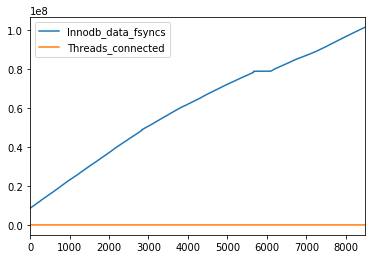

In [95]:
#visualize raw data
df.plot()
pyplot.show()

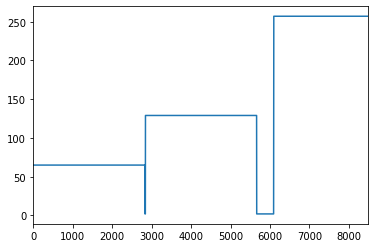

In [96]:
#Threads_connected looked flat but let's look in detail.
df['Threads_connected'].plot()
pyplot.show()

In [70]:
#first difference
df['diff'] = df['Innodb_data_fsyncs'] - df['Innodb_data_fsyncs'].shift(1)

In [73]:
#check
df.head()

,Innodb_data_fsyncs,Threads_connected,diff
timestamp,,,
2019-04-18 21:06:02.141726,8503802,65,NaN
2019-04-18 21:06:07.260973,8526335,65,22533.0
2019-04-18 21:06:12.344215,8548645,65,22310.0
2019-04-18 21:06:17.436656,8570947,65,22302.0
2019-04-18 21:06:22.525223,8593404,65,22457.0


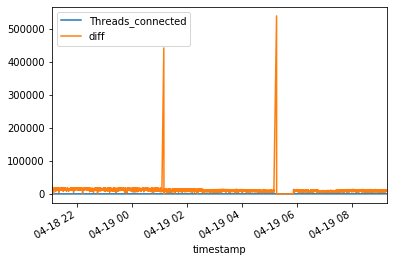

In [77]:
#visualizing first diff'd threads, looks like that did the trick
df[['Threads_connected','diff']].plot()
pyplot.show()

In [83]:
#ran Augmented Dickey Fuller to check for non-stationarity before the transform and the result confirms it
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Innodb_data_fsyncs'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.221202
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


I started with visualizing the raw feature data - threads and fsyncs. fsyncs appeared to be a runaway process, reminding me of a memory leak I'd see in AWS. Threads looked nearly flat given the scale of fsyncs in the plt plot but isolating and visualizing that feature showed it to be more of a step function. I don't think it requires a transform since it appears to be scaling to demand the way that nodes ramp up and down like electrical lode or an HPC/distribued computing process. I made a first difference variable for fsyncs though, since any variability/spikes would be hidden given that the sheer ascent of the series makes visual discrimination of jumps impossible. This reveals 2 distinct spikes but otherwise shows a level, stationary series. The 2 drops in threads corresponds temporally to the 2 spikes in fsyncs, so we'd do well to dig into why the threads went down.